# Programming for Data Science and Artificial Intelligence

## Supervised Learning - Classification - K-Nearest Neighbors

### Readings: 
- [VANDER] Ch5
- [HASTIE] Ch9, 13

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## K-Nearest Neighbors

The intuition behind the KNN algorithm is one of the simplest of all the supervised machine learning algorithms. It simply calculates the distance of a new data point to all other training data points. The distance can be of any type e.g Euclidean or Manhattan etc. It then selects the K-nearest data points, where K can be any integer. Finally it assigns the data point to the class to which the majority of the K data points belong.

For example, given the red cross X, it simply get the majority class of neighbors, and assign to its own.

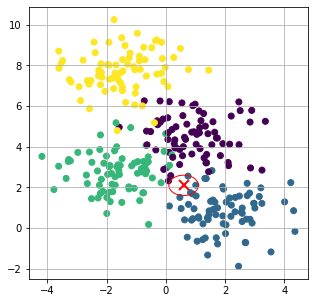

In [2]:
#let's consider the following 2D data with 4 classes
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)

xfit = np.linspace(-1, 3.5)

figure = plt.figure(figsize=(5, 5))
ax = plt.axes()  #get the instance of axes from plt

ax.grid()
ax.scatter(X[:, 0], X[:, 1], c=y)

#where should this value be classified as?
ax.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

#let's say roughly 5 neighbors
circle = plt.Circle((0.6, 2.1), 0.5, color='red', fill=False)
ax.add_artist(circle)

### Scratch

**Implementation steps:**

1. Prepare your data
    - $X$ and $y$ in the right shape
        - $X$ -> $(m, n)$
        - $y$ -> $(m, )$
        - Why no w?
    - train-test split
    - feature scale
    - clean out any missing data
    - (optional) feature engineering
2. Write a function for computing pairwise distance between every points
3. Then, given set of X_test data, compute their distance to all other points, then argsort the distance matrix, and get the k-nearest indices
4. Get the majority class

#### 1. Prepare your data

In [3]:
#standardize
scaler = StandardScaler()
X = scaler.fit_transform(X)

#do train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### 2. Function for pairwise distance

I have written three different ways in numpy assignment answer question 11

In [4]:
def find_distance(X_train, X_test): #<--look Numpy Assignment Answer Question 11
    #create newaxis simply so that broadcast to all values
    dist = X_test[:, np.newaxis, :] - X_train[np.newaxis, :, :]
    sq_dist = dist ** 2
    
    #sum across feature dimension, thus axis = 2
    summed_dist = sq_dist.sum(axis=2)
    sq_dist = np.sqrt(summed_dist)
    return sq_dist

#### 3. Argsort the pairwise distance matrix

In [5]:
def find_neighbors(X_train, X_test, k=3):
    dist = find_distance(X_train, X_test)
    #return the first k neighbors
    neighbors_ix = np.argsort(dist)[:, 0:k]
    return neighbors_ix

#### 4. Get the majority class

In [6]:
#https://numpy.org/doc/stable/reference/generated/numpy.bincount.html
def get_most_common(y):
    return np.bincount(y).argmax()

#### Let's write a wrapper function that links all function and use it

In [7]:
from sklearn.metrics import average_precision_score, classification_report
from sklearn.preprocessing import label_binarize

def predict(X_train, X_test, y_train, k=3):
    neighbors_ix = find_neighbors(X_train, X_test, k)
    pred = np.zeros(X_test.shape[0])
    for ix, y in enumerate(y_train[neighbors_ix]):
        pred[ix] = get_most_common(y)
    return pred

yhat = predict(X_train, X_test, y_train, k=3)

n_classes = len(np.unique(y_test))

print("Accuracy: ", np.sum(yhat == y_test)/len(y_test))

print("=========Average precision score=======")
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])
yhat_binarized = label_binarize(yhat, classes=[0, 1, 2, 3])

for i in range(n_classes):
    class_score = average_precision_score(y_test_binarized[:, i], yhat_binarized[:, i])
    print(f"Class {i} score: ", class_score)
    
print("=========Classification report=======")
print("Report: ", classification_report(y_test, yhat))

Accuracy:  0.9222222222222223
=========Average precision score=======
Class 0 score:  0.7409090909090909
Class 1 score:  0.929513888888889
Class 2 score:  0.8866666666666666
Class 3 score:  0.926984126984127
=========Classification report=======
Report:                precision    recall  f1-score   support

           0       0.77      0.94      0.85        18
           1       0.96      0.96      0.96        24
           2       0.96      0.89      0.92        27
           3       1.00      0.90      0.95        21

    accuracy                           0.92        90
   macro avg       0.92      0.92      0.92        90
weighted avg       0.93      0.92      0.92        90



### Sklearn

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV

model = KNeighborsClassifier()
param_grid = {"n_neighbors": np.arange(2, 10)}

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(model, param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)

print(f"The best parameters are {grid.best_params_} with" +
          f"a score of {grid.best_score_:.2f}")

model = grid.best_estimator_

model.fit(X_train, y_train)
yhat = model.predict(X_test)

print("Accuracy: ", np.sum(yhat == y_test)/len(y_test))

print("=========Average precision score=======")
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])
yhat_binarized = label_binarize(yhat, classes=[0, 1, 2, 3])

for i in range(n_classes):
    class_score = average_precision_score(y_test_binarized[:, i], yhat_binarized[:, i])
    print(f"Class {i} score: ", class_score)
    
print("=========Classification report=======")
print("Report: ", classification_report(y_test, yhat))

The best parameters are {'n_neighbors': 3} witha score of 0.95
Accuracy:  0.9222222222222223
=========Average precision score=======
Class 0 score:  0.7409090909090909
Class 1 score:  0.929513888888889
Class 2 score:  0.8866666666666666
Class 3 score:  0.926984126984127
=========Classification report=======
Report:                precision    recall  f1-score   support

           0       0.77      0.94      0.85        18
           1       0.96      0.96      0.96        24
           2       0.96      0.89      0.92        27
           3       1.00      0.90      0.95        21

    accuracy                           0.92        90
   macro avg       0.92      0.92      0.92        90
weighted avg       0.93      0.92      0.92        90



### ===Task===

Your work: Let's modify the above scratch code to
- If the majority class of the first place is equal to the second place, then ask the algorithm to pick the next nearest neighbors as the decider
- Modify the code so it outputs the probability of the decision, where the probability is simply the class probability based on all the nearest neighbors
- Write a function which allows the program to receive a range of k, and output the cross validation score.  Last, it shall inform us which k is the best to use from a predefined range
- Put everything into a class <code>KNN(k=3)</code>.  It should have at least one method, <code>predict(X_train, X_test, y_train)

### When to use KNN

I guess the only good thing about it is that KNN is super easy to implement, and generally work quite well on simple classification problems.  However, it also comes with a price:

- Computational expense as feature grows, since it requires computing the distance for each feature, where for each feature, we have to compute the input points with every single points, then perform sort (which can be expensive), and then get the majority class from the nearest nth-neighbors.  Very expensive!
- Can't work with categorical features since it is difficult to formulate distance formulas for categorial features
- Of course, it takes even more time to find the right n_neighbors (or commonly known as k)